<a href="http://www.stfc.ac.uk/"> <img src="../../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


In [1]:
import sys, math, pickle
import numpy
sys.path.append('../../lib/')
#import addopt, addopt_model, Kernel
import Kernel

from sklearn import svm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import train_test_split

from rdkit import Chem
import pandas  

import matplotlib.pyplot as plt
%matplotlib notebook
'imported'

'imported'

[Up](Methods.ipynb)  

## SVM Regression
So far, we have used Support Vector Machines for [classification](SVC.ipynb). Now, let's build a regression model of solubility of some organic molecules. We have already prepared the data when we were building a [neural net for regression](../../ANN/ANNR.ipynb)


In [2]:

with open( "../../model_data/solubility_gm_fp.p", "rb" ) as f:
    training_fp, train_y, test_fp, test_y, train_m, test_m = pickle.load(f)

Support Vector Regression 
==============

/root/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


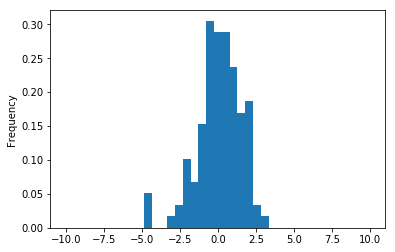

Number of support vectors: 141  R Squared: 0.5249154986580618


In [3]:
from sklearn import utils
from rdkit import DataStructs

def gram_matrix(X, Y=None):
    if Y:
        pass
    else:
        Y = X
    gm = numpy.zeros([len(X), len(Y)], dtype=numpy.float64) 
    for i in range(0, len(X)):
        for j in range(0, len(Y)):
            gm[i, j] =  DataStructs.FingerprintSimilarity(X[i],Y[j], 
                metric=DataStructs.cDataStructs.TanimotoSimilarity)
    return numpy.array(gm, dtype=numpy.float64)

#fingerprint = lambda m: Chem.rdmolops.RDKFingerprint(m, maxPath=3)
#
# see http://scikit-learn.org/stable/modules/generated/sklearn.svm.NuSVR.html
model = svm.NuSVR(kernel='precomputed', 
                # degree=3, gamma='auto', coef0=0.0, # all irrelevant with precomputed kernel
                tol=1e-2, # tolerance for stopping, should match experimental error
                # C=1, # lower values imply more regularization
                nu=0.1, # default is 0.5
) 

# Can be slow. Time is square of size of training set.
training_gm = gram_matrix(list(training_fp))  

model.fit(
        training_gm, # precomputed
        train_y,  # dependent values, to be predicted
)

test_gm = gram_matrix(list(test_fp), list(training_fp))
predicted = model.predict( test_gm )
residuals = test_y - predicted
# rmse = math.sqrt(mean_squared_error(y, predicted))
rsquare = r2_score(test_y,predicted)

# pickle the gram matrices for future use
with open( "../../model_data/solubility_gm.p", "wb" ) as f:
    pickle.dump( (training_fp, training_gm, train_y, test_fp, test_gm, test_y, train_m, test_m), f )
                
# display results
plt.figure()
#plt.xlabel('Residual delHSub. RSquared: %(rsq)g %(kernel)s' %{"rsq":rsquare, "kernel":kernel.__repr__()})
plt.ylabel('Frequency')
plt.hist(residuals, bins=numpy.linspace(-10, 10, 40), normed=1)
plt.show()
print('Number of support vectors: {}  R Squared: {}'.format( len(model.support_), rsquare ))

## How it works

The method chooses a subset of molecules $\{s_1, s_2, ...\}$ from the training set, at least $nu \times |training|$. These are referred to as "support vectors". It also chooses weights w1, w2, ... The prediction for a test molecule m is:
$$     \sum_i{w_i k(m, s_i) }$$

The weights are calculated by a linear regression. This is a nonlinear model, but all the nonlinearity is in the kernel function k which you have supplied.

## The parameters of nuSVM
C : float, optional (default=1.0)

    Regularization parameter.

nu : float, optional

     A lower bound of the fraction of support vectors. Should be in the interval (0, 1] 
    
shrinking : boolean, optional (default=True)

    Whether to use the shrinking heuristic.

An alternative method, epsilon-SVR, uses a parameter epsilon instead of nu. This is harder to interpret, so we prefer nuSVR.



## Search for optimal parameters 
In the code above, we accepted the default for C, and nu was set to value lower than the default. Find the optimal value for these parameters using sklearn.model_selection.GridSearchCV. You can then use the code below to plot your results.

In [4]:
from sklearn.model_selection import GridSearchCV

#let's use 10-fold cross validation, iterating through a range of values for nu and C.

parameters = {
    'nu': numpy.arange(0.05, 0.2, 0.05),
    'C': numpy.arange(0.5, 5, .05)
    #, Could: 'tol': numpy.arange(0.005, 0.02, 0.005) # default is 0.001 but we set it to 0.01 above
}

grid_search = GridSearchCV(model,parameters,cv=10, scoring="r2", return_train_score=True)
grid_search.fit(training_gm,train_y)
grid_search.best_estimator_

NuSVR(C=4.950000000000004, cache_size=200, coef0=0.0, degree=3, gamma='auto',
   kernel='precomputed', max_iter=-1, nu=0.2, shrinking=True, tol=0.01,
   verbose=False)

## Visualize the results of the grid search

In [ ]:

%matplotlib notebook

results = grid_search.cv_results_

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#best_nu = parameters['nu'][ numpy.where(mean_accuracy_scores==max_accuracy)[0][0] ]

ax.plot_trisurf(
    results["param_nu"].data.tolist(),
    results["param_C"].data.tolist(),
    results["mean_train_score"], 
    alpha=0.2, color='red'
)
ax.plot_trisurf(
    results["param_nu"].data.tolist(),
    results["param_C"].data.tolist(),
    results["mean_test_score"], 
    alpha=0.2, color='blue'
)

#plt.scatter(parameters['nu'],mean_accuracy_scores)
ax.set_xlabel("Nu")
ax.set_ylabel("C")
ax.set_zlim(0,1)
ax.set_zlabel('R Squared')
ax.mouse_init()
plt.show()

print("Optimised model is:\n {} \nR**2 {}".format(grid_search.best_estimator_, max(grid_search.cv_results_["mean_test_score"])))

<div class="alert alert-warning" role="alert">
**Discussion:** What are the best values of nu, C, and tol?<br>
**Exercise:** $R^2$ is poor, and the residual distribution is far from normal. This fingerprint gave us a good model for the classification problem, but not such a good regression. 
<ul>
    <li>Try a larger radius</li>
    <li>Try another fingerprint.</li></div>

In [ ]:
# Exercise: try varying these defaults
#fingerprint = lambda m: Chem.rdMolDescriptors.GetHashedAtomPairFingerprintAsBitVect(m,
#    minLength=1 , maxLength=30 , # distance in bonds between atoms to consider as a pair                                            
#)


<div class="alert alert-warning" role="alert">
**Advanced Exercise:** try integer vector fingerprints from http://www.rdkit.org/docs-beta/api/rdkit.DataStructs.cDataStructs-module.html. </div>



See also
=====
* http://rdkit.readthedocs.io/en/latest/GettingStartedInPython.html#fingerprinting-and-molecular-similarity 
* http://rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf 
* https://www.ncbi.nlm.nih.gov/pubmed/16157471
* https://pdfs.semanticscholar.org/688b/38811ac8eecb378102bc1c4e8a9938b60691.pdf
* [Gaussian Process Regression](Optional/GPR.ipynb)

[Next](Visualization.ipynb)
[Up](Welcome.ipynb) [Support Vector Classification](SVC.ipynb) [Previous](SVM.ipynb)

Copyright STFC 2018